In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Checks for available GPUs and lists them
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Set TensorFlow to use only the first GPU
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2024-03-10 14:54:24.418276: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 14:54:24.418332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 14:54:24.419695: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-10 14:54:24.425924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 14:54:25.342899: W tensorflow/compiler/tf2

1 Physical GPU, 1 Logical GPU


2024-03-10 14:54:26.634404: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 14:54:27.274342: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 14:54:27.274387: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 14:54:27.276159: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 14:54:27.276244: I external/local_xla/xla/stream_executor

In [2]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0


In [3]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

# Reshape data for SVD
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Apply SVD
n_components = 150  # You can vary this
svd = TruncatedSVD(n_components=n_components)
x_train_svd = svd.fit_transform(x_train_flat)
x_test_svd = svd.transform(x_test_flat)

# Reshape data back for CNN input
# Adjusted reshape for the SVD output
x_train_svd = x_train_svd.reshape(x_train.shape[0], n_components, 1, 1)
x_test_svd = x_test_svd.reshape(x_test.shape[0], n_components, 1, 1)


In [4]:
# Convert the data to a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_svd, y_train))

# Define a function for data augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

# Apply data augmentation to the training dataset
train_dataset = train_dataset.map(augment)


2024-03-10 14:54:37.937901: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 72000000 exceeds 10% of free system memory.
2024-03-10 14:54:45.103607: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 72000000 exceeds 10% of free system memory.


In [5]:
# Adjusted model for SVD output
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(n_components, 1, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Epoch 1/25


2024-03-10 14:54:45.545053: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 72000000 exceeds 10% of free system memory.


2024-03-10 14:54:47.158774: I external/local_xla/xla/service/service.cc:168] XLA service 0xa75bbd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-10 14:54:47.158853: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-03-10 14:54:47.175512: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-10 14:54:47.211946: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1710075287.339952   69187 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 [==============================] - 11s 5ms/step - loss: 0.3765 - accuracy: 0.8940
Epoch 2/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1707 - accuracy: 0.9516
Epoch 3/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1240 - accuracy: 0.9638
Epoch 4/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1003 - accuracy: 0.9709
Epoch 5/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0843 - accuracy: 0.9746
Epoch 6/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0739 - accuracy: 0.9780
Epoch 7/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0646 - accuracy: 0.9808
Epoch 8/25
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0577 - accuracy: 0.9824
Epoch 9/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0524 - accuracy: 0.9838
Epoch 10/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0503 - accura

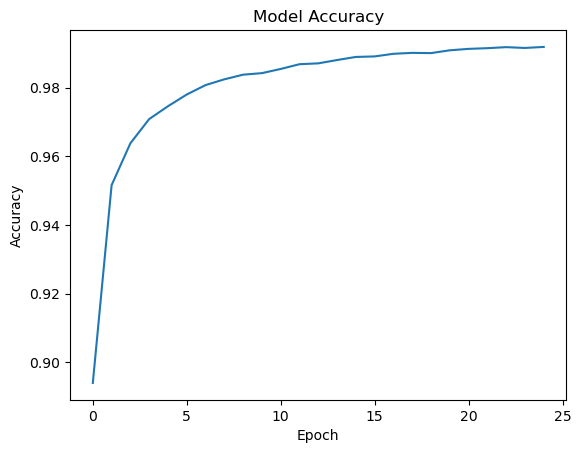

ValueError: in user code:

    File "/home/avers/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/home/avers/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/avers/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/home/avers/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "/home/avers/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/avers/.local/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 150, 1, 1), found shape=(None, 28, 28)


In [6]:
# Lists to store accuracy values for plotting
history = model.fit(train_dataset.batch(32), epochs=25)

# Plot accuracy per epoch
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Evaluate the model on the test data
model.evaluate(x_test, y_test)